<br/><font size="6"><b>Taxi at airports. Time series</b></font>.<br/>

<a name="1common."></a>
## <a name="0.0"></a>Content:
* [0. Loading libraries and self-written functions](#0.)
* [1. Data preparation](#1.)
* [2. Analysis](#2.)
* [3. Training](#3.)
* [4. Testing](#4.)
* [5. Checking the model for adequacy](#5.)
* [Сonclusions](#6.)

# Description of the project

Based on historical data on taxi orders, you need to build a model to predict the number of taxi orders for the next hour.

*The value of the **RMSE** metric on the test sample should not exceed 48.*

## Description of data

The data is in the `taxi.csv` file. The number of orders is in the '*num_orders*' column.

<aname="0."></a><br/>
<font size="6"><b>0. Loading libraries and self-written functions</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from termcolor import colored

import warnings
import time
import random
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
def bold():
     return "\033[1m"

def bold_end():
     return "\033[0m"

#Set the format for numbers
pd.options.display.float_format = '{:>10.2f}'.format

#Remove warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#**Function print_basic_info, to display information about the array and its variables.**

#* base - database name
#* info - 1: output information about the array, other: no output
#* describe - 1: output description of array variables, other: no output
#* duplicat - 1: print the number of full duplicates
#* head - n: base example output (output n - lines), n < 1: no output

def print_basic_info(base, info, describe, duplicate, head):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print(base.info())
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicate == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

<a name="1."></a><br/>
<font size="6"><b>1. Data preparation</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

Открывая файл сразу сделаем из даты индекс 

In [4]:
#I work locally, the online path in the hub is slightly different ('/datasets/...')

df_taxi = pd.read_csv('datasets/taxi.csv', sep=',',decimal='.', index_col = 'datetime', parse_dates=[0])

print_basic_info(df_taxi,1,1,0,3)


  info  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

  head 


num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28


  describe  


  num_orders  
 count     26496.00
mean         14.07
std           9.21
min           0.00
25%           8.00
50%          13.00
75%          19.00
max         119.00
Name: num_orders, dtype: float64


We only have the result and the date.

A total of 26496 cases. All are filled.

In [5]:
df_taxi.sort_index(inplace=True, ascending=False)

In [6]:
# Check if the dates are monotonic

df_taxi.sort_index(inplace=True, ascending=False)

def is_monotonic(data):
    if data.index.is_monotonic == True:
        print(bold(), colored('Sorted by date','green') , bold_end(), "\n")
        return data
    else:
        print(bold(), colored('Not sorted by date','red') , bold_end(), "\n")
        data.sort_index(inplace=True)
        return is_monotonic(data)

In [7]:
#For the convenience of repeating the data processing process, we will make a function

steps_clean = [is_monotonic]

def clean_data(data, steps_clean):
    for step in steps_clean:
        print(bold(), colored((str(step).split()[1]),'blue'), bold_end(), "\n")
        data = step(data)
    return data

data_clean = clean_data(df_taxi, steps_clean)

 is_monotonic  

 Not sorted by date  

 Sorted by date  



In [8]:
# merge data by 1 hour
def resample_h(data):
    data = data.resample('1H').sum()
    print(bold(), colored('Resample - 1 hour','green') , bold_end(), "\n")
    return data

step = (resample_h)
if (steps_clean[-1] != step):
        steps_clean.append(step)

data_clean = clean_data(df_taxi, steps_clean)

 is_monotonic  

 Sorted by date  

 resample_h  

 Resample - 1 hour  



In [9]:
# see how many cases
print_basic_info(data_clean,1,1,0,0)


  info  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

  describe  


  num_orders  
 count      4416.00
mean         84.42
std          45.02
min           0.00
25%          54.00
50%          78.00
75%         107.00
max         462.00
Name: num_orders, dtype: float64


Great, there are fewer cases because the data was summed up

**Add information by year, month, day and day of the week**

In [10]:
def data_info(data):
    data['year'] = data.index.year
    print(bold(), colored('Variable - year','green'), bold_end(), "\n")
    
    data['month'] = data.index.month
    print(bold(), colored('Variable - month','green'), bold_end(), "\n")
    
    data['day'] = data.index.day
    print(bold(), colored('Variable day','green'), bold_end(), "\n")
    
    data['dayofweek'] = data.index.dayofweek
    print(bold(), colored('Variable - day of the week','green'), bold_end(), "\n")
    
    data['hour'] = data.index.hour
    print(bold(), colored('Variable - hour','green'), bold_end(), "\n")
    
    return data

step = data_info
if (steps_clean[-1] != step):
        steps_clean.append(step)

data_clean = clean_data(df_taxi, steps_clean)

 is_monotonic  

 Sorted by date  

 resample_h  

 Resample - 1 hour  

 data_info  

 Variable - year  

 Variable - month  

 Variable day  

 Variable - day of the week  

 Variable - hour  



In [11]:
print_basic_info(data_clean,1,0,0,0)


  info  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   year        4416 non-null   int64
 2   month       4416 non-null   int64
 3   day         4416 non-null   int64
 4   dayofweek   4416 non-null   int64
 5   hour        4416 non-null   int64
dtypes: int64(6)
memory usage: 241.5 KB
None


<a name="2."></a><br/>
<font size="6"><b>2. Анализ</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

**To analyze the data, let's look at the patterns in general.
Let's take a moving average for the day. Also see the trend**

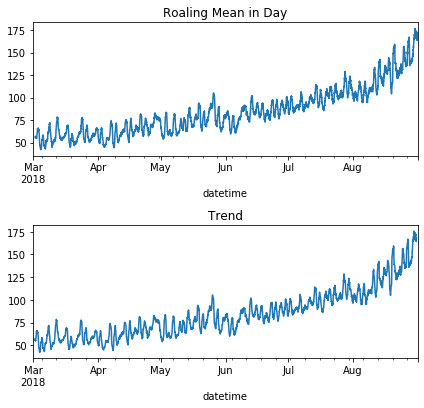

In [12]:
decomposed =  seasonal_decompose(data_clean['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
data_clean['num_orders'].rolling(24).mean().plot()
plt.title('Roaling Mean in Day')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.tight_layout()

* Moving average for the day completely coincides with the calculated trend. Now we know how the trend is calculated

* In general, there is a tendency to increase orders

* However, seasonality cannot be assessed because we only have data for one year.

**Let's see the dependence on the day of the week**

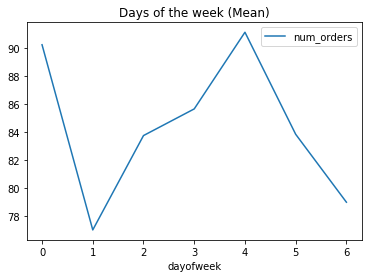

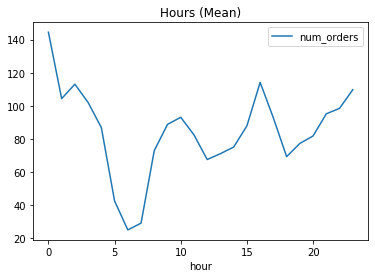

In [13]:
data_clean.pivot_table(index='dayofweek', values='num_orders', aggfunc='mean').plot()
plt.title('Days of the week (Mean)')
plt.show()


data_clean.pivot_table(index='hour', values='num_orders', aggfunc='mean').plot()
plt.title('Hours (Mean)')
plt.show()

* Based on average number of calls:
    * The most popular days for calling a taxi are Monday and Friday.
    * Peak time is around midnight

<a name="3."></a><br/>
<font size="6"><b>3. Training</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

Let's make a convenient function so that you can calculate the shifts and the moving average and split the target and features

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    # according to specification test_size = 10%
    # shuffle=False because we work with time series and are not psychics
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train = train.drop(['num_orders'], axis='columns')
    features_test = test.drop(['num_orders'], axis='columns')
    
    target_train = train['num_orders']
    target_test = test['num_orders']
    
    return features_train, features_test, target_train, target_test
    
# Let's start with a shift for every hour of the week. Let's take the moving average per day
features_train, features_test, target_train, target_test = make_features(data_clean, 24*7, 24)

/Users/lesia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lesia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [15]:
print(features_train.shape,target_train.shape, features_test.shape, target_test.shape)

(3806, 174) (3806,) (442, 174) (442,)


In [16]:
#shuffle=False - because we need whole temporary chunks
cv = KFold(n_splits=5, random_state=1234, shuffle=False)

In [17]:
#Lasso

grid = {'alpha' : [i for i in np.arange(0.1,0.9,0.1)]}

clf = Lasso(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

Lasso_best_params = gs.best_params_
print(Lasso_best_params)

/Users/lesia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182987.36410176952, tolerance: 473.26549031198687
  positive)
/Users/lesia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321581.17597957177, tolerance: 479.8392334975368
  positive)
/Users/lesia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143514.69906874804, tolerance: 478.7635240065682
  positive)


{'alpha': 0.8}


In [18]:
#LassoCV

from sklearn.linear_model import LassoCV

grid = {'n_alphas' : [i for i in range(1,20)] }

clf = LassoCV(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

LassoCV_best_params = gs.best_params_
print(LassoCV_best_params)

{'n_alphas': 12}


In [19]:
#OrthogonalMatchingPursuit

grid = {'precompute' : [True, False, 'auto']}

clf = OrthogonalMatchingPursuit()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

OrthogonalMatchingPursuit_best_params = gs.best_params_
print(OrthogonalMatchingPursuit_best_params)

{'precompute': True}


In [20]:
#BayesianRidge

grid = {'n_iter' : [i for i in range(1,200)]}

clf = BayesianRidge()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

BayesianRidge_best_params = gs.best_params_
print(BayesianRidge_best_params)

{'n_iter': 5}


In [21]:
#Ridge

grid = {'alpha' : [i for i in np.arange(0.1,0.9,0.1)]}

clf = Ridge()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

Ridge_best_params = gs.best_params_
print(Ridge_best_params)

{'alpha': 0.8}


In [22]:
#LinearRegression

grid = {'normalize' : [True, False]}
clf = LinearRegression()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_squared_error')
gs.fit(features_train,target_train)

LinearRegression_best_params = gs.best_params_
print(LinearRegression_best_params)

{'normalize': False}


In [23]:
#make a function that will record the training time, prediction rate, and prediction quality (RMSE)
def put_in_base(model_name, base_res, features_train, target_train):
    features_train.reset_index(drop = True, inplace = True)
    target_train.reset_index(drop = True, inplace = True)
    cv = KFold(n_splits = 3, shuffle=True, random_state=241)
    time_train, time_predict, RMSE = [], [], []
    for train_index, val_index in cv.split(features_train):
        X_train, X_val = features_train.loc[train_index], features_train.loc[val_index]
        y_train, y_val = target_train.loc[train_index], target_train.loc[val_index]
        #studying time.
        start_time = time.time()
        model_name.fit(X_train, y_train)
        time_train.append(round((time.time() - start_time),3))
        #prediction speed.
        start_time = time.time()
        predictions_valid = model_name.predict(X_val)
        time_predict.append(round((time.time() - start_time),3))
        #prediction quality(RMSE)
        RMSE.append(mean_squared_error(y_val, predictions_valid)**0.5)
    
    base_res.loc[str(clf).split('(')[0],'time_train'] = np.mean(time_train)
    base_res.loc[str(clf).split('(')[0],'time_predict'] = np.mean(time_predict)
    base_res.loc[str(clf).split('(')[0],'RMSE'] = np.mean(RMSE)
    return base_res

In [24]:
ans = pd.DataFrame()

for clf in (Lasso(random_state = 123, alpha = 0.8),
            LassoCV(n_alphas = 5, random_state = 123),
            OrthogonalMatchingPursuit(precompute = False),
            BayesianRidge(n_iter =  5),
            Ridge(random_state = 123, alpha = 0.8),
            LinearRegression(normalize =False)
           ):
    put_in_base(clf, ans, features_train, target_train)
    

In [25]:
display(ans.sort_values(by = 'RMSE'))

time_train  time_predict       RMSE
LassoCV                          0.32          0.00      21.30
OrthogonalMatchingPursuit        0.02          0.00      21.48
BayesianRidge                    0.11          0.00      21.49
Lasso                            0.30          0.00      21.67
Ridge                            0.02          0.00      21.75
LinearRegression                 0.07          0.00      21.76

**We will use LassoCV**. This model has the lowest RMSE

<a name="4."></a><br/>
<font size="6"><b>4. Тестирование</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [26]:
#make a function that will record the training time, prediction rate, and prediction quality (RMSE)
def put_in_base_test(model_name, base_res, features_train, target_train, features_test, target_test):
    
    #studying time.
    start_time = time.time()
    model_name.fit(features_train, target_train)
    base_res.loc['fin','time_train'] = round((time.time() - start_time),3)
    
    #prediction speed.
    start_time = time.time()
    predictions_test = model_name.predict(features_test)
    base_res.loc['fin','time_predict'] = round((time.time() - start_time),3)
    
    #prediction quality(RMSE)
    base_res.loc['fin','RMSE'] = mean_squared_error(target_test, predictions_test)**0.5
    
    return predictions_test, model_name, base_res

In [27]:
info_final_test = pd.DataFrame()
final_model = LassoCV(n_alphas = 5, random_state = 123)
predictions_test, final_model, info_final_test = put_in_base_test(final_model, info_final_test, 
                                                                  features_train, target_train, 
                                                                  features_test, target_test)

In [28]:
display(info_final_test)

time_train  time_predict       RMSE
fin        0.35          0.00      34.47

The RMSE indicator is lower than the maximum for the TK, which is good.

<a name="5."></a><br/>
<font size="6"><b>5. Checking the model for adequacy</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

To check for adequacy, we compare the indicator
    * with median on the test set
    * with "past hour"

In [29]:
# All test sample values are predicted by the same number (constant). Let's take the median
pred_median = np.ones(target_test.shape) * target_train.median()
print("RMSE:", mean_squared_error(target_test, pred_median)**0.5)

RMSE: 86.41465855206327


In [30]:
# The new value x(t) is predicted by the previous value of the series, i.e. x(t-1)
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE:", mean_squared_error(target_test, pred_previous)**0.5)

RMSE: 58.856486242815066


RMSE нашей модели значительно ниже.

In [31]:
#### Export the model
# save the model for further work outside the book
joblib.dump(final_model, 'model_taxi_timelines_LassoCV.joblib')

['model_taxi_timelines_LassoCV.joblib']

<a name="6."></a><br/>
<font size="6"><b>
Сonclusions</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

**Based on historical data on taxi orders, a model was built to predict the number of taxi orders for the next hour.**
     
*When evaluating the model, it is necessary to minimize the **RMSE** evaluation criterion (on the test sample, its indicator should not exceed 48). Our test sample model has an RMSE measure of 34 orders*

**Model built based on customer behavior data based on:**

* ***As part of data preparation, we have converted time to ***
    * year - year
    * month - month
    * day - day
    * dayofweek - day of the week
    * hour - hour
    
* ***And also, based on the data on orders in the past hours, variables were identified***
    * lag_... - shift in the number of orders per hour in a week (total 24 * 7 variables)
    * rolling_mean - moving average per day
    
    
***Target feature***

*num_orders — number of orders*


**Model built with "LassoCV", with parameters:**

* n_alphas = 5
* random_state = 123


**You can download the model named <font color='blue'> model_taxi_timelines_LassoCV.joblib
</font>**